In [85]:
import os
import subprocess
from fractions import Fraction
import json

def compute_grammar(score, measure_quarter_lenght= None,delete_rests = False):  
    #measure quarter_length is used to check if the metric is correct
    
    grammar_input_path = "grammars_test/vert_grammar1.txt"
    script_path = "to complete"
    timeline_path= "timelines/temp_tim1.txt"

    failure_counter = 0  # to keep track of the number of failure
    wrong_sum_counter = 0 #to keep track of the number of bars that do not sum to the correct value
    total_measures = 0 #to keep track of the complete number of measures
    flatMeasuresDurations = []
    # save the duration tree for each bar
    for part_index, part in enumerate(score.parts):  # loop through parts
        for measure_index, measure_with_rests in enumerate(part.getElementsByClass('Measure')):
            total_measures += 1
            if len(measure_with_rests.voices) == 0:  # there is a single Voice ( == for the library there are no voices)
                if delete_rests:
                    measure = delete_rests(measure_with_rests)
                else: 
                     measure=measure_with_rests
                note_list = list(measure.getElementsByClass('GeneralNote'))
                if measure_quarter_lenght is None: #append everything
                    flatMeasuresDurations.append(note_list)
                else: #append only the measure that sum to the correct value
                        if sum([n.duration.quarterLength for n in note_list]) == measure_quarter_lenght:
                            flatMeasuresDurations.append(note_list)
                        else:
                            wrong_sum_counter +=1
            else:  # there are multiple voices (or an array with just one voice)
                for voice_with_rest in measure_with_rests.voices:
                    if delete_rests:
                        voice = delete_rests(voice_with_rest)
                    else:
                        voice = voice_with_rest
                    note_list = list(voice.getElementsByClass('GeneralNote'))
                    if measure_quarter_lenght is None: #append everything
                        flatMeasuresDurations.append(note_list)
                    else: #append only the measure that sum to the correct value
                        if sum([n.duration.quarterLength for n in note_list]) == measure_quarter_lenght:
                            flatMeasuresDurations.append(note_list)
                        else:
                            wrong_sum_counter +=1
                                
                            

    # process and sum over all the bars
    sum_rule = {}  

    for dur in flatMeasuresDurations:
        try:
            c_input = save_timeline(dur, timeline_path)
            unix_command = "{0} -v 0 -i {1} -a {2} -penalty -inference".format(script_path,timeline_path, grammar_input_path)
            if os.name == 'nt': #on windows, we call the ubuntu bash
                c_output = subprocess.check_output(["bash", "-c", unix_command])
            else:
                c_output = subprocess.check_output(unix_command, shell=True)
            rule_list = json.loads(c_output.decode("utf-8").splitlines()[8]) #some useless stuff in the first 7 rows
            sum_rule = { k: sum_rule.get(k, 0) + rule_list.get(k, 0) for k in set(sum_rule) | set(rule_list) } #"sum" the two dictionaries
        except:
            failure_counter += 1
    
    return sum_rule, failure_counter, wrong_sum_counter, total_measures

In [5]:
#function to save the list of durations

def save_timeline(notes, path):
    durs = [Fraction(note.duration.quarterLength) for note in notes]
    normalized_dur = [Fraction(dur/sum(durs)) for dur in durs]
    dur_string = ""
    for n_dur in normalized_dur:
        dur_string = "{0}{1}\n".format(dur_string, str(n_dur.numerator)+ "/"+str(n_dur.denominator))
    dur_string = dur_string + "\n"
    dur_string = dur_string[0:-1] #delete last comma
    with open(os.path.join(path), "w") as f:
        f.write(dur_string)
    return dur_string

## Take the dataset from music21

In [87]:
from music21 import corpus
corp = corpus.search('3/4')
print(len(corp))

1875


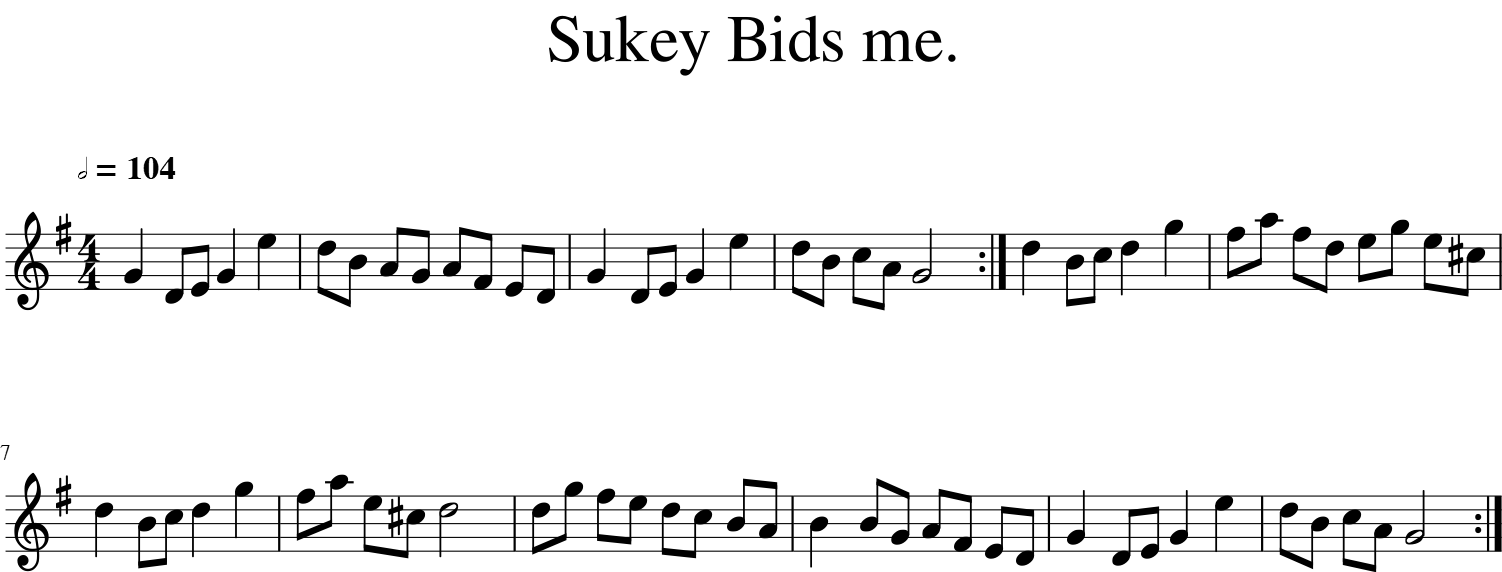

In [84]:
corp[0].parse().show()

In [88]:
music21_44 = pd.DataFrame(columns=['title','measures','wrong_sum_measures','failed_trees','used_rules'], index=range(len(corp)))
music21_44

print("Creating a dataframe with {0} scores".format([len(corp)]))

for index, unparsed_score in enumerate(corp):
    score= unparsed_score.parse()
    print("Score {0}: {1}".format(index,score.metadata.title)) 
    sum_rule, fail, wrong_sum, total_measures= compute_grammar(score, measure_quarter_lenght=3)
    music21_44.loc[index]= [score.metadata.title, total_measures, wrong_sum, fail, sum_rule ]

music21_44.to_pickle("dataframes/music21_34.pkl")
music21_44

Creating a dataframe with [1875] scores
Score 0: Pompey ran away.
Score 1: Ross Castle.
Score 2: The Sutors of Selkirk.
Score 3: The King's Anthem.
Score 4: Water parted from the Sea.
Score 5: Capt. O Kain.
Score 6: In Wine there is all.
Score 7: The Trim built Wherry.
Score 8: The Shepherd Adonis.
Score 9: A Favourite Ballad from Robin Hood
Score 10: The Free Masson's Anthem.
Score 11: Logie o' Buchan.
Score 12: Miss Callander's Minuet.
Score 13: Tweed Side.
Score 14: MacGregor Aruaro.
Score 15: Queen Mary's Lamentation.
Score 16: Sally in our Alley.
Score 17: My time o ye Muses.
Score 18: Peggy Bawn.
Score 19: Lay by your wheel Betty.
Score 20: Laddie ly near me.
Score 21: Aileen Aroon,
Score 22: Bannocks of barley meal.
Score 23: Lady Coventry's Minuet.
Score 24: Death of Admiral Benbow
Score 25: Afton Water.
Score 26: A bonny young lad is my Jockey.
Score 27: Princess Royal's Minuet.
Score 28: I'll never leave thee.
Score 29: Coolun,
Score 30: Love will find out the way.
Score 31: 

Score 261: Maedchen als Stallknecht
Score 262: Die fuenf Soehne
Score 263: Maedchen als Stallknecht
Score 264: Die zehnte Tochter
Score 265: Das boese Stiefmuetterlein
Score 266: Maedchen als Stallknecht
Score 267: Das Traenenkrueglein
Score 268: Der Vorwirt
Score 269: Die verunglueckte Muellerstochter
Score 270: Die Rabenmutter
Score 271: Waise und Stiefmutter
Score 272: Die Rabenmutter
Score 273: Die zwei armen Waislein
Score 274: Richmudis von Adocht
Score 275: Die Rabenmutter
Score 276: Der Vorwirt
Score 277: Das neue Grab
Score 278: Das Traenenkrueglein
Score 279: Die Rabenmutter
Score 280: Tod der Geschwister
Score 281: Tod der Geschwister
Score 282: Das Traenenkrueglein
Score 283: Tochter als Faehnrich
Score 284: Die zwei armen Waislein
Score 285: Der Vorwirt
Score 286: Die zwei armen Waislein
Score 287: Die Antwerpener Kaufmannstochter
Score 288: Das boese Stiefmuetterlein
Score 289: Die Hauptmannstochter
Score 290: Der ehebrecherische Gatte
Score 291: Das Traenenkrueglein
Scor

Score 476: WONI GEH UND STEH
Score 477: DER MENSCH SOLL NICHT STOLZ SEIN
Score 478: UEBERALL BIN ICH ZU HAUSE
Score 479: SCHON HABEN VIEL DICHTER
Score 480: DER BESTE FREUND IST IN DEM HIMMEL
Score 481: ICH KOMME VOM GEBIRGE HER
Score 482: MORGEN MUESSEN WIR VERREISEN
Score 483: WILT HEDEN NU TREDEN VOOR GOD
Score 484: DRUNTEN IM UNTERLAND
Score 485: SCHLAFE KINDLEIN HOLD UND SUESS
Score 486: ICH KOMME VOM GEBIRGE HER
Score 487: HELFT LEUTCHEN MIR VOM WAGEN DOCH
Score 488: VON MEINEN BERGEN MUSS I SCHEIDE
Score 489: BRUEDER LASST UNS GEHN ZUSAMMEN
Score 490: AN DER SAALE HELLEM STRANDE
Score 491: NUN LEB WOHL DU KLEINE GASSE
Score 492: Haerzke, menj Haerzken, do faer iwerm Rech,
Score 493: Die verwundete Dame
Score 494: Schlangenkoechin
Score 495: Schlangenkoechin
Score 496: Magelhan (Rolling home)
Score 497: Uebers Bacherl bin i gschprunga,
Score 498: 's Geigenbuebele
Score 499: Schloss in Oestreich
Score 500: Der goldene Rosenkranz
Score 501: Echo - Jodel
Score 502: Ach schoenster Sc

Score 678: GRAF FRIEDRICH WOLLT AUSREITEN
Score 679: ES WARN EINMAL ZWEI BAUERNSOEHN
Score 680: SIE GLEICHT WOL EINEM ROSENSTOCK
Score 681: ES IST FUERWAHR KEIN KREATUR
Score 682: DIE EULE AUF DEM ZAUNE SASS
Score 683: ES LIEGT EIN SCHLOSS IN OESTERREICH
Score 684: ES LEUCHTET SCHON WIEDER
Score 685: KOMM ZU MIR IN GARTEN
Score 686: AUF DIESER WELT HAB ICH KEIN FREUD
Score 687: ACH SCHOENSTER SCHATZ MEIN AUGENTROST
Score 688: WILT DU MEI SEI
Score 689: WENN ICH NOCH LEDIG WAER
Score 690: ES SPIELT EIN GRAF MIT EINER MAGD
Score 691: ES WOLLT EIN MAEDL ZUM TANZE GEHN
Score 692: ICH STAND AUF HOHEN BERGEN
Score 693: ES HATT EIN GASTWIRTH EINEN SOHN
Score 694: GESTERN ABEND IN DER STILLEN RUH
Score 695: ES SASS EIN KAEFER AUF DEM BAEUMEL
Score 696: ES WAR EINMAL EIN BRAVER HUSAR
Score 697: ES WAREN ZWEI GESPIELEN
Score 698: DREI LAUB AUF EINER LINDEN
Score 699: ES STEHT EIN LIND IN JENEM THAL
Score 700: ES STEHT EIN SCHLOSS IN OESTERREICH
Score 701: WIE HOCH IST DER HIMMEL
Score 702: S IST

Score 880: CA CA GESCHMAUSET
Score 881: GUTN ABEND JUNGFR RESL
Score 882: HABT IHR LUST IHR LIEBEN BRUEDER
Score 883: GEH ICH HIN UEBER DIE ALM
Score 884: ES FUHR GEN ACKER EIN GROBER BAUER
Score 885: DIE REISE NACH SUEDLAND
Score 886: ES REISTEN DREI SCHAEFER AUS BRESLAU RAUS
Score 887: HEUT IST EIN FREUDENREICHER TAG
Score 888: HIER TRETEN WIR HER
Score 889: AUF DER ALMA DORT FINDEN DIE KUEH
Score 890: AF AF EHS HIAERTN
Score 891: DER HIMMEL STEHT OFFEN
Score 892: DORT UNTEN IM THAELE
Score 893: BEI SEDAN AUF DEN HOEHEN
Score 894: ZU HAUS GEDENKT MAN MEINER NICHT
Score 895: WAS TRAEGT DIE GANS
Score 896: DREI WOCHEN VOR OSTERN
Score 897: ZUM SOLDAT BIN ICH GEBOREN
Score 898: SUSE LEWE SUSE
Score 899: LUSTIG LUSTIG IHR LIEBEN BRUEDER
Score 900: WAS SOLL DAS BEDEUTEN
Score 901: VOM HIMMEL HOCH IHR ENGEL KOMMT
Score 902: WENN DER TOPP ABER NUN  A LOCH HAT
Score 903: DIE HEILGEN DREI KOENIG
Score 904: WENN DIE HOFFNUNG NICHT WAER
Score 905: MUENSTER ICH MUSS DICH VERLASSEN
Score 906: UND

Score 1090: Da mai ge
Score 1091: Luoshui tian
Score 1092: Xin xiu hebao liangmian hong
Score 1093: Ritou chulai shai shangang
Score 1094: Gusu fengguang(Da jiulianhuan)
Score 1095: Xin bian de Shange,yong che la
Score 1096: Shier ge yue
Score 1097: Wo shuo laoban shi tiao niu
Score 1098: Hao cao ge
Score 1099: Dui hua mi
Score 1100: Shixuxie
Score 1101: Hama diao
Score 1102: Yigen sixian qianguo he
Score 1103: Zhua bing diao
Score 1104: Zha chazi
Score 1105: Xundian shange
Score 1106: Pan ge
Score 1107: Anning minge
Score 1108: Cha tian ge
Score 1109: Gao shan diao
Score 1110: Xinda suobiao liangmian guang
Score 1111: Luo shui tian
Score 1112: Changgong diao
Score 1113: Mengjiangnu
Score 1114: Chang yang ge
Score 1115: Chutou ge
Score 1116: Chashan duichang
Score 1117: Molihua
Score 1118: Sanba diao
Score 1119: Yiduo xianhua shui di kai
Score 1120: Jinnian niantou xiyiangayiang
Score 1121: Tujia changqi fengshouge
Score 1122: Suqu zhengquan kaihonghua
Score 1123: Qiongren xiaodiao
Sco

Score 1294: Knigskinder (2-28) S. 85
Score 1295: Knig Balthasar (2-15) S. 51
Score 1296: Lied vom steinernen Brot (3-26), S. 85
Score 1297: Der mit der spitze Kapp (4-99), S. 134
Score 1298: Ritter Sent Jerry (3-14), S. 51
Score 1299: Judenvesper (4-95), S. 126
Score 1300: Mdchen und Baum (2-68) S. 205
Score 1301: Am Samstag Abend (2-72) S. 217
Score 1302: Es reit't ein Reiter (Band 1), S. 103
Score 1303: Nachtigall, wo ist gut wohnen (5-91), S. 143
Score 1304: Ein Jngling wollte wandern (5.64), S. 105
Score 1305: Es zog ein Matrose (5-83), S. 132f
Score 1306: Es fliegen zwei Tauben (3-91), S. 251
Score 1307: Feiner Knab (2-87) S. 255
Score 1308: Neujahrslied, (Band 1), S. 13
Score 1309: Laá' beten, o Christengemeinde (5-45), S. 76
Score 1310: Wenn ich des Nachts vor dem Feuerlein steh (3-78), S. 217
Score 1311: Am Abend, eh ich schlafen geh (Band 1), S. 205
Score 1312: Bauer und Schneider (3-45), S. 133
Score 1313: Als Gott den Adam hat erschaff'n, S. 43
Score 1314: Zaldotemarsch 

Score 1473: "Der sterbende Krieger"
Score 1474: EY MAI LIEBE MALCHEN HIE
Score 1475: "Vergeblich"
Score 1476: SPINN SPINNE MEINE LIEBE TOCHTER
Score 1477: "Die Mordfranzosen"
Score 1478: "Das Daennerl im Thal"
Score 1479: "Der Teppichkraemer"
Score 1480: O TANNENBAUM O TANNENBAUM
Score 1481: "Im Wald bei der Amsel"
Score 1482: "Die Feldwacht"
Score 1483: "Fruehlingshoffnung"
Score 1484: "Genoveva"
Score 1485: "Lilliput"
Score 1486: "Die Spinnerin"
Score 1487: ES WAR EIN MARKGRAF UEBERN RHEIN
Score 1488: EIN MAEDCHEN VON ACHTZEHN JAHREN
Score 1489: "Auf der Alm"
Score 1490: ES SOLL SICH JA KEINER MIT DER LIEBE ABGEBEN
Score 1491: "Muenchen"
Score 1492: KEIN FEUER, KEINE KOHLE KANN BRENNEN SO HEISS
Score 1493: BIN I A LUSTIGA FUHRMANNSSOHN
Score 1494: Die Hartherzige"
Score 1495: ADE MEIN SCHATZ ICH MUSS NUN FORT
Score 1496: "Argwohn"
Score 1497: "Der Kohlenbauer"
Score 1498: MAEDCHEN STEH AUF UND LASS MICH EIN
Score 1499: "Sehnsucht"
Score 1500: AUF DIESER WELT HAB ICH KEIN FREUD
Score 

Score 1714: The Old Cloak
Score 1715: On the Mountain Side
Score 1716: A Place In Thy Memory
Score 1717: The New Apron
Score 1718: Achil Air
Score 1719: Young Kate of Kilcummer
Score 1720: The Charming Fair Maid
Score 1721: Summer Evening
Score 1722: The Green Woods of Truigha
Score 1723: I'm Sadly Thinking
Score 1724: You Never Saw Rosey
Score 1725: Peggy Bawn
Score 1726: The Pearl of the Flowing Tresses
Score 1727: Nancy My Pride
Score 1728: Bally Patrick
Score 1729: The Bride of Malahide
Score 1730: The Forlorn Lover
Score 1731: Kate Kearnel
Score 1732: The Young Black Cow
Score 1733: Castle Hyde
Score 1734: I'll Be a Good Boy
Score 1735: The Young Lady
Score 1736: I Will Drink No More
Score 1737: Thy Fair Bosom
Score 1738: The Alewoman
Score 1739: The Humors of the Joyce Country
Score 1740: SLIGO AIR
Score 1741: FORGET NOT THE ANGELS
Score 1742: THE REJECTED LOVER
Score 1743: LOUGH SHEELING
Score 1744: DERMOT
Score 1745: THE GIRL FROM LOWER IRELAND
Score 1746: ONE WIFE IS ENOUGH FO

,title,measures,wrong_sum_measures,failed_trees,used_rules
0,Pompey ran away.,12,0,0,"{'53': 44, '4': 12, '71': 14, '73': 22}"
1,Ross Castle.,15,6,0,"{'55': 8, '3': 7, '53': 23, '4': 2, '8': 5, '7..."
2,The Sutors of Selkirk.,25,1,2,"{'3': 3, '53': 40, '70': 4, '4': 19, '71': 42,..."
3,The King's Anthem.,17,0,9,"{'19': 1, '13': 1, '53': 6, '15': 1, '4': 4, '..."
4,Water parted from the Sea.,48,1,2,"{'53': 22, '70': 12, '4': 41, '6': 1, '71': 96..."
5,Capt. O Kain.,26,4,4,"{'55': 1, '3': 3, '53': 25, '70': 2, '4': 15, ..."
6,In Wine there is all.,17,6,8,"{'4': 3, '71': 8, '70': 1}"
7,The Trim built Wherry.,19,4,1,"{'19': 1, '13': 1, '53': 35, '15': 1, '4': 6, ..."
8,The Shepherd Adonis.,18,4,6,"{'55': 1, '3': 2, '53': 5, '70': 2, '4': 6, '6..."
9,A Favourite Ballad from Robin Hood,17,4,0,"{'3': 8, '53': 43, '4': 5, '6': 7, '71': 7, '9..."


## Take the dataset from EWLD

In [93]:
import sqlite3

EWLD_path = "to complete"

conn = sqlite3.connect(EWLD_path)
c = conn.cursor()

In [111]:
metric = '6/8'
c.execute('SELECT features_path FROM features WHERE metric= ?', (metric,))

dataset = c.fetchall()  
print(len(dataset))

dataset

def csv_to_mxl(string):
    return string[0:-3] + "mxl"

paths = []

for d in dataset:
    paths.append(csv_to_mxl(d[0]))
    
paths

101


['dataset/[Unknown]/Caroling,_Caroling/Caroling,_Caroling.mxl',
 'dataset/Carolyn_Leigh-Cy_Coleman/Pass_Me_By/Pass_Me_By.mxl',
 'dataset/[Unknown]/Geef_Mij_De_Liefde_En_De_Gein/Geef_Mij_De_Liefde_En_De_Gein.mxl',
 'dataset/[Unknown]/He_Hideth_My_Soul/He_Hideth_My_Soul.mxl',
 'dataset/Herb_Hendler-Ralph_Flanagan/Hot_Toddy/Hot_Toddy.mxl',
 'dataset/[Unknown]/Mister_Ed/Mister_Ed.mxl',
 "dataset/[Unknown]/Saint_Patrick's_Day_in_the_Morning/Saint_Patrick's_Day_in_the_Morning.mxl",
 'dataset/Teri_Moïse/Les_poèmes_de_Michelle/Les_poèmes_de_Michelle.mxl',
 'dataset/[Unknown]/Love,_Here_Is_My_Heart/Love,_Here_Is_My_Heart.mxl',
 'dataset/George_Bennard/The_Old_Rugged_Cross/The_Old_Rugged_Cross.mxl',
 'dataset/[Unknown]/Het_Dondert_En_Het_Bliksemt/Het_Dondert_En_Het_Bliksemt.mxl',
 'dataset/[Unknown]/Band_Of_Brothers_Theme/Band_Of_Brothers_Theme.mxl',
 'dataset/Jay_Rifkin-Lebo_M-Mark_Mancina/He_Lives_in_You/He_Lives_in_You.mxl',
 'dataset/Alex_Callier/Vinegar_&_Salt/Vinegar_&_Salt.mxl',
 "dataset

In [112]:
from music21 import converter

ewld = pd.DataFrame(columns=['title','measures','wrong_sum_measures','failed_trees','used_rules'], index=range(len(paths)))

print("Creating a dataframe with {0} scores".format([len(paths)]))

for index, p in enumerate(paths):
    try:
        score = converter.parse(EWLD_path + p )
        print("Score {0}: {1}".format(index,score.metadata.title)) 
        sum_rule, fail, wrong_sum, total_measures= compute_grammar(score, measure_quarter_lenght=3)
        ewld.loc[index]= [score.metadata.title, total_measures, wrong_sum, fail, sum_rule ]
    except:
        print("Failed for path: " + str(p))

ewld.to_pickle("dataframes/ewld_68.pkl")
ewld

Creating a dataframe with [101] scores
Score 0: Caroling, Caroling
Score 1: Pass Me By
Score 2: Geef Mij De Liefde En De Gein
Score 3: He Hideth My Soul
Score 4: Hot Toddy
Score 5: Mister Ed
Score 6: Saint Patrick's Day in the Morning
Score 7: POEME
Score 8: Love, Here Is My Heart
Score 9: The Old Rugged Cross
Score 10: Het Dondert En Het Bliksemt
Score 11: Band Of Brothers Theme
Score 12: He Lives
Score 13: Vinegar & Salt
Score 14: Tarantella
Score 15: Nights In White Satin - Flute Solo
Score 16: When I Dream Of Old Erin
Score 17: Funiculi,  Funicula
Score 18: Repasz Band
Failed for path: dataset/[Unknown]/"SEASIDE,_YET_DOCKED"/"SEASIDE,_YET_DOCKED".mxl
Score 20: FLOWER DUET from LAKME
Score 21: America
Score 22: Hallelujah
Failed for path: dataset/Donna_Fargo/The_Happiest_Girl_in_the_Whole_U.S.A./The_Happiest_Girl_in_the_Whole_U.S.A..mxl
Failed for path: dataset/Max_Steiner/Theme_from_"A_Summer_Place"/Theme_from_"A_Summer_Place".mxl
Score 25: Laudate Dominum
Score 26: I've Got A Love

,title,measures,wrong_sum_measures,failed_trees,used_rules
0,"Caroling, Caroling",32,0,0,"{'3': 14, '53': 70, '70': 8, '4': 18, '6': 20,..."
1,Pass Me By,44,0,3,"{'3': 21, '53': 74, '4': 16, '1': 4, '6': 32, ..."
2,Geef Mij De Liefde En De Gein,76,1,0,"{'3': 45, '53': 119, '4': 30, '6': 79, '71': 3..."
3,He Hideth My Soul,19,2,0,"{'39': 15, '3': 17, '11': 15, '53': 37, '6': 4..."
4,Hot Toddy,42,0,3,"{'4': 30, '1': 9, '71': 30, '52': 30, '73': 60..."
5,Mister Ed,45,1,5,"{'3': 17, '53': 121, '70': 1, '4': 19, '1': 3,..."
6,Saint Patrick's Day in the Morning,17,4,0,"{'39': 1, '3': 12, '11': 1, '53': 68, '4': 1, ..."
7,POEME,32,0,2,"{'6': 31, '3': 30, '53': 80, '52': 7, '9': 29}"
8,"Love, Here Is My Heart",25,0,5,"{'39': 7, '55': 7, '3': 19, '53': 74, '4': 1, ..."
9,The Old Rugged Cross,97,0,75,"{'71': 60, '4': 21, '1': 1, '70': 3}"
